In [1]:
import pandas as pd

all_postings = pd.read_csv('job_postings_unprocessed.csv')

print(all_postings.shape)
# remove NaN in pay_period
all_postings = all_postings.dropna(subset=['pay_period'])
print(all_postings.columns)
print(all_postings.shape)


(33246, 28)
Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped'],
      dtype='object')
(13352, 28)


Only 13352 out of 33246 rows in this dataset include salary information in 'pay_period' column

In [3]:
postings_salary = all_postings.loc[:, ['title','description', 'max_salary', 'med_salary', 'min_salary', 'pay_period']]
  
print(postings_salary.head())
# drop rows where max_salary, med_salary, and min_salary are all NaN
postings_salary = postings_salary.dropna(subset=['max_salary', 'med_salary', 'min_salary'], how='all')


                                          title  \
0                         Hearing Care Provider   
3                                          Cook   
4   Principal Cloud Security Architect (Remote)   
8                                    Dishwasher   
11             Insights Analyst - Auto Industry   

                                          description  max_salary  med_salary  \
0   Overview\n\nHearingLife is a national hearing ...         NaN     5250.00   
3   descriptionTitle\n\n Looking for a great oppor...         NaN       22.27   
4   Job Summary\nAt iHerb, we are on a mission to ...    275834.0         NaN   
8   descriptionTitle\n\n $2,000 Sign-on Bonus Guar...         NaN       19.30   
11  Who We Are\n\nEscalent is an award-winning dat...     64000.0         NaN   

    min_salary pay_period  
0          NaN    MONTHLY  
3          NaN     HOURLY  
4     205956.0     YEARLY  
8          NaN     HOURLY  
11     58000.0     YEARLY  


In [4]:
# combine title and description into one column "combined_text"
postings_salary['combined_text'] = postings_salary['title'] + ' ' + postings_salary['description']

### Calculate annual salary from median salary and pay period information

In [5]:

# average max and min salary to med_salary if med_salary is NaN and max_salary and min_salary are not NaN
postings_salary['med_salary'] = postings_salary['med_salary'].fillna((postings_salary['max_salary'] + postings_salary['min_salary']) / 2)

# drop entry where med_salary is 0
postings_salary = postings_salary[postings_salary['med_salary'] != 0]



In [6]:
postings_salary['pay_period'].unique()
print(postings_salary.shape)

(13350, 7)


Final processed dataset with full salary information has 13350 entries

In [7]:
# using med_salary and pay_period to average annual salary
def get_annual_salary(row):
    # assume 40 hours per week 
    if row['pay_period'] == 'HOURLY':
        return row['med_salary'] * 40 * 52
    elif row['pay_period'] == 'WEEKLY':
        return row['med_salary'] * 52
    elif row['pay_period'] == 'MONTHLY':
        return row['med_salary'] * 12
    elif row['pay_period'] == 'YEARLY':
        return row['med_salary']
    elif row['pay_period'] == 'ONCE':
        return row['med_salary']
    

postings_salary['annual_salary'] = postings_salary.apply(get_annual_salary, axis=1)




In [8]:
# describe the annual salary data
print(postings_salary['annual_salary'].describe())


count    1.335000e+04
mean     1.425794e+05
std      3.416309e+06
min      1.350000e+01
25%      5.200000e+04
50%      8.250000e+04
75%      1.238000e+05
max      3.432000e+08
Name: annual_salary, dtype: float64


### Group salary into 4 brackets: 0-50k, 50k-100k, 100k-150k, 150k+

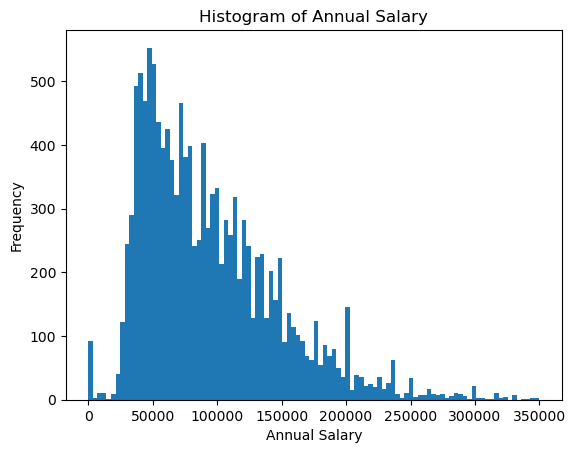

In [9]:
# historgram of annual salary
import matplotlib.pyplot as plt
plt.hist(postings_salary['annual_salary'], bins=100, range=(0, 350000))
plt.xlabel('Annual Salary')
plt.ylabel('Frequency')
plt.title('Histogram of Annual Salary')
plt.show()

In [10]:
# categorize salary into ranges
def categorize_salary(salary):
    if salary < 50000:
        return '0-50k'
    elif salary < 100000:
        return '50k-100k'
    elif salary < 150000:
        return '100k-150k'
    else:
        return '150k+'
    
postings_salary['salary_range'] = postings_salary['annual_salary'].apply(categorize_salary)


In [11]:

def categorize_salary_bin(salary_range):
    if salary_range == '0-50k':
        return 0
    elif salary_range == '50k-100k':
        return 1
    elif salary_range == '100k-150k':
        return 2
    else:
        return 3

postings_salary['salary_bin'] = postings_salary['salary_range'].apply(categorize_salary_bin)

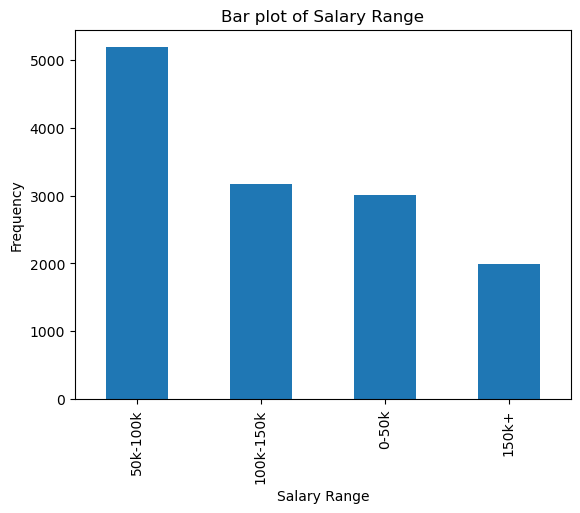

In [82]:
# print bar plot of each salary range
salary_range_counts = postings_salary['salary_range'].value_counts()
salary_range_counts.plot(kind='bar')
plt.xlabel('Salary Range')
plt.ylabel('Frequency')
plt.title('Bar plot of Salary Range')
plt.show()


In [83]:
header = ['combined_text', 'annual_salary', 'salary_range', 'salary_bin']
postings_salary = postings_salary.loc[:, header]
postings_salary.to_csv('job_postings_salary.csv', index=False)
print(postings_salary.head())

                                        combined_text  annual_salary  \
0   Hearing Care Provider Overview\n\nHearingLife ...        63000.0   
3   Cook descriptionTitle\n\n Looking for a great ...        46321.6   
4   Principal Cloud Security Architect (Remote) Jo...       240895.0   
8   Dishwasher descriptionTitle\n\n $2,000 Sign-on...        40144.0   
11  Insights Analyst - Auto Industry Who We Are\n\...        61000.0   

   salary_range  salary_bin  
0      50k-100k           1  
3         0-50k           0  
4         150k+           3  
8         0-50k           0  
11     50k-100k           1  
